# MACS3 Exam 2025-2026

Author: Fredson SILVA DE SOUZA AGUIAR

## Configuration

For configuration, the following relevant variables should be taken in consideration. This includes, e.g., the filepath for the stores.

In [1]:
storepath = "/home/fredson-aguiar/Downloads/dfdr1000/Aircraft_01.h5"
cleanstorepath = "/home/fredson-aguiar/Downloads/dfdr1000/Aircraft_01_clean.h5"

# output table and metadata
tablepath = "/home/fredson-aguiar/Downloads/dfdr1000/Aircraft_01.csv"
metadatapath = "/home/fredson-aguiar/Downloads/dfdr1000/Aircraft_01.pkl"

samples_per_phase = 10

cruise_threshold=0.95
land_threshold=0.05

## Data Cleansing

We starting by cleaning the data, that is, removing inadequate data. This includes eliminating flight records without samples, or other extreme cases. We also fix time indexing whenever possible.

For this step, we follow: https://github.com/jee51/tabata

In [2]:
from tabata import Opset

import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

In [3]:
store = Opset(storepath)

print("Loaded store available in file:", store.storename)
print("Number of flight registers:", len(store))

Loaded store available in file: /home/fredson-aguiar/Downloads/dfdr1000/Aircraft_01.h5
Number of flight registers: 1002


A DataFrame example, stored in the storage:

In [4]:
store.df.head()

,ALT [ft],EGT_1 [deg C],EGT_2 [deg C],FMV_1 [mm],FMV_2 [mm],HPTACC_1 [%],HPTACC_2 [%],M [Mach],N1_1 [% rpm],N1_2 [% rpm],...,VIB_AN1_1 [mils],VIB_AN1_2 [mils],VIB_AN2_1 [ips],VIB_AN2_2 [ips],VIB_BN1_1 [mils],VIB_BN1_2 [mils],VIB_BN2_1 [ips],VIB_BN2_2 [ips],VSV_1 [mm],VSV_2 [mm]
record_00,,,,,,,,,,,,,,,,,,,,,
0,-4.636641,33.494949,33.494949,-0.64553,-0.64913,4.637541,34.737062,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.59227,56.529748
1,-4.636641,33.494949,33.494949,-0.64553,-0.64913,4.637541,34.737062,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.59227,56.529748
2,-4.636641,33.494949,33.494949,-0.64553,-0.64913,4.696870,34.737062,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.59227,56.592270
3,-4.636641,33.494949,33.494949,-0.64553,-0.64913,4.696870,34.737062,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.59227,56.529748
4,-4.636641,33.494949,33.494949,-0.64553,-0.64913,4.696870,34.737062,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.59227,56.529748


We clean the data by removing inadequate DataFrames. In this case, we remove the datasets with are incomplete, that is, DataFrames with no lenght (no samples) or no feature columns. We also check for the hight distrubutions and define a threshold the minimum high requires for the flight to be effective: is this case, as can be seen in the next graph, there is a clear separation, so we also remove flights that do not achieve a maximun altitude of at least 20k feet.

Text(0.5, 1.0, 'distribution of minimum hights')

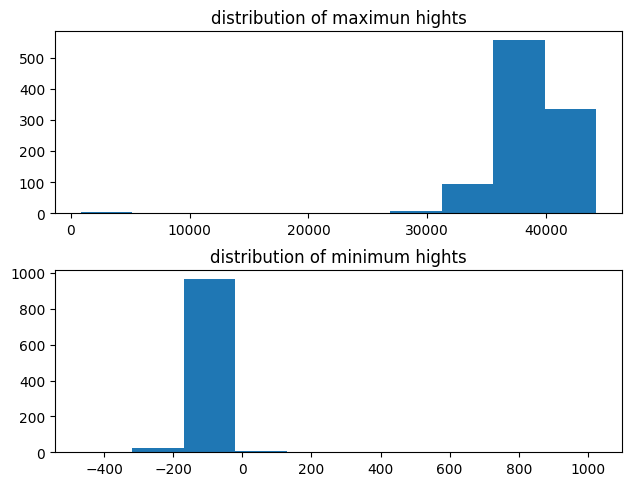

In [5]:
max_alts = []
min_alts = []

for df in store:
    if 'ALT [ft]' in df.columns:
        max_alts.append(df["ALT [ft]"].max())
        min_alts.append(df["ALT [ft]"].min())

# plot
fig, ax = plt.subplots(2)
fig.tight_layout(h_pad=2)

ax[0].hist(max_alts)
ax[0].set_title("distribution of maximun hights")

ax[1].hist(min_alts)
ax[1].set_title("distribution of minimum hights")

In [6]:
cleanstore = Opset(cleanstorepath)
cleanstore.clean()

to_remove = []
for df in store:
    if df.shape[0] > 0 and df.shape[1] > 0 and df["ALT [ft]"].max() > 20000:
        df.reset_index()
        cleanstore.put(df)
    else:
        to_remove.append(df.index.name)

print("Clean store in file:", cleanstore.storename)
print("Indexes saved:", len(cleanstore))
print("Indexes removed:", len(to_remove))
print("Removed names:", to_remove)

Clean store in file: /home/fredson-aguiar/Downloads/dfdr1000/Aircraft_01_clean.h5
Indexes saved: 996
Indexes removed: 6
Removed names: ['record_06', 'record_07', 'record_08', 'record_09', 'record_651', 'record_702']


## Rectangularization

After cleaning our data and removing aberrant inputs, we are able to propose methods for Tabulation or Rectangularization. The idea is to format the different flight data in a uniform representation. By doing that, we expect to achieve the following:
 * Data Compression: the normalization method can be used to represent the different flight data, which can be extensive, in a dense, relativelly low-dimensional format. This should ultimatelly result in a data compression method
 * Normal Representation: by formatting out data in tabular form, a uniform representation, we should be able to apply easily classical and moder machine learning techniques for Anomaly Detection, Simulation, or even Forther Compression, among other possibilities.

### Proposed Rectangularization

We propose the following Rectangularization method: for each variable of interest (e.g. "ALT [ft]", "M [Mach]", etc.), the sequence of measurements will be converted in a shorter sequence, or vector, of fixed lenght $L$. On the other side, each complete dataset contains a number $N$ of flights (around 1000), so ech complete dataset can be expressed as a new table of the form $M \in \mathbb{R}^{N \times L}$, where each row contains a latent, vectorial, representation of a single flight, and the number of rows is the number of distinct flights in the dataset. Finally, the number $L$ of columns is a hyperparameter to be set, and has direct impact on the dimensionality reduction rate.

The method for mapping a flight (measure) to a representative vector is described later. For now, we highlight some important aspects to be taken in consideration:
 * flight phases: different flight phases might have different durations, in special the cruise phase duration can vary stremelly among different occurences, thus one must not take time samples uniformly distributed among the flight duration, since in this case cruise time migt be overrepresented in some cases, and underrepresented in other. Instead, we consider a uniform time grid for each flight phase.
 * moving average: on the other side, we highlight that by taking a fixed number of samples per phase, we incurr the risk of missing relevant extremal values measured between the chosen frame, for this reason, at each time index taken in consideration, we take an average (simple or weighted using a kernel) os the closest points centered in the measured time.
 * normalization: finally, we normalize the measurements per flight, so each resulting table will present values in $[0,1]$.

An issue that appears when we propose the use of different fligh phases to obtain a representative sample is that the dataset "dfdr1000" in question does not include information about the fligh phases. We propose a simple approach to estimate such phases without access to data. we consider five flight phases: 
 * cruise: we assume cruise phase starts when we achieve 99% of the maximum altitude, and finishes when the altitude falls back under the same treshold;
 * taxi_out: we assume that the taxi_out phase initiates at the begining of each sample, and finishes when the altitude surpassses 1% of the maximun altitude;
 * taxi_in: similarly, we assume that the taxi_in is the last phase and that it starts when, for the last time, the altutude crosses the 1% , after cruise;
 * climb and descent: will be defined simply as the intermediate phases.

Alternativelly, if we had access to labeled data, one could train a classification model based, for instance, in Recurrent Neral Networks, suitable for sequential data. We observe an example of this approach in the following:

In [7]:
def get_phase_indexes(df, cruise_threshold, land_threshold):
    # get cruise indexes
    top_alt = df["ALT [ft]"] >= df["ALT [ft]"].max()*cruise_threshold
    cruise_in = df.index[top_alt].min()
    cruise_out = df.index[top_alt].max()
    
    # get taxi_out index
    out_df = df[df.index <= cruise_in].copy()
    out_df = out_df[out_df.index >= np.argmin(out_df["ALT [ft]"])]
    out_df["ALT [ft]"] = out_df["ALT [ft]"] - out_df["ALT [ft]"].min()
    out_alt = out_df["ALT [ft]"] >= out_df["ALT [ft]"].max()*land_threshold
    taxi_out = out_df.index[out_alt].min()
    
    # get taxi_in index
    in_df = df[df.index >= cruise_out].copy()
    # in_df = in_df[in_df.index <= np.argmin(in_df)]
    in_df["ALT [ft]"] = in_df["ALT [ft]"] - in_df["ALT [ft]"].min()
    out_alt = in_df["ALT [ft]"] >= in_df["ALT [ft]"].max()*land_threshold
    taxi_in = in_df.index[out_alt].max()

    return taxi_out, cruise_in, cruise_out, taxi_in

In [8]:
# get indexes
df = cleanstore[2]
taxi_out, cruise_in, cruise_out, taxi_in = get_phase_indexes(df, cruise_threshold, land_threshold)

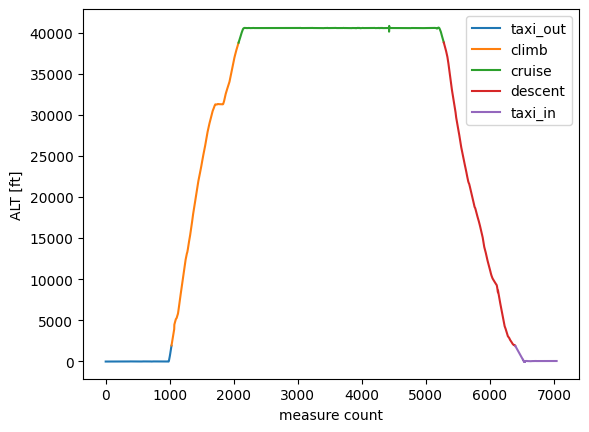

In [9]:
plt.plot(df.index[:taxi_out], df["ALT [ft]"][:taxi_out], label="taxi_out")
plt.plot(df.index[taxi_out:cruise_in], df["ALT [ft]"][taxi_out:cruise_in], label="climb")
plt.plot(df.index[cruise_in:cruise_out], df["ALT [ft]"][cruise_in:cruise_out], label="cruise")
plt.plot(df.index[cruise_out:taxi_in], df["ALT [ft]"][cruise_out:taxi_in], label="descent")
plt.plot(df.index[taxi_in:], df["ALT [ft]"][taxi_in:], label="taxi_in")

plt.ylabel("ALT [ft]")
plt.xlabel("measure count")
plt.legend()
plt.show()

### Flight to Vector

Now that we are able to identify the different flight phases, we are finally ready to map a complete flight data in a single normalized vetor, as follows.

Let $(m^{v, p}_i)_{i=0}^{k}$ be the sequence of measurements for a given variabel of interest, $v$ in a given phase $p$; here, $k$ mih vary between differrent flght samples. Without loss of generality, we take $L+1$ indexes $0 = t_0 \leq t_1 \leq \cdots \leq t_{L} = k$, where different indexes may be repeated (which can be the case if the sample is too short). With those, simply define $u_j = \frac{\sum_{i=t_{j-1}}^{t_j} m^{v, p}_i }{t_j-t_{-1}}$, that is, just take the average of the measurements indexed in the corresponding interval, this given us a vector $u \in \mathbb{R}^L$ that represents the original data. Then, simply do the same for each flight phase and concatenate all resulting vectors to obtain our final representation. Finally, normalize $u$ in the interval $[0,1]$.

Alternativelly to the average in each interval, one could take the meadian or other central tendency value.

In [10]:
def flight_to_vector_phase(sequence, L):
    K = len(sequence)
    # defines intervals
    inds = np.interp(range(L+1), [0, L], [0, K]).astype(int)

    # mount mean vector
    u = np.empty(L)
    for i in range(1,len(inds)):
        if inds[i-1]==inds[i]:
            u[i-1] = sequence[inds[i-1]]
        else:
            u[i-1] = sequence[inds[i-1]:inds[i]].mean()
    
    return u
    
def flight_to_vector(df, colname, L):
    # get phases
    taxi_out, cruise_in, cruise_out, taxi_in = get_phase_indexes(df, cruise_threshold, land_threshold)
    
    phases = [
        df[colname].array[:taxi_out],
        df[colname].array[taxi_out:cruise_in],
        df[colname].array[cruise_in:cruise_out],
        df[colname].array[cruise_out:taxi_in],
        df[colname].array[taxi_in:]
    ]
    
    # get vector
    vectors = []
    for phase in phases:
        vector_phase = flight_to_vector_phase(phase, L)
        vectors.append(vector_phase)

    # concatenate
    vector = np.concat(vectors)

    vec_min = vector.min()
    vec_var = vector.max() - vector.min()
    vector = (vector-vec_min)/vec_var

    phase_indexes = [0, taxi_out, cruise_in, cruise_out, taxi_in, df.shape[0]]
    return vector, vec_min, vec_var, phase_indexes

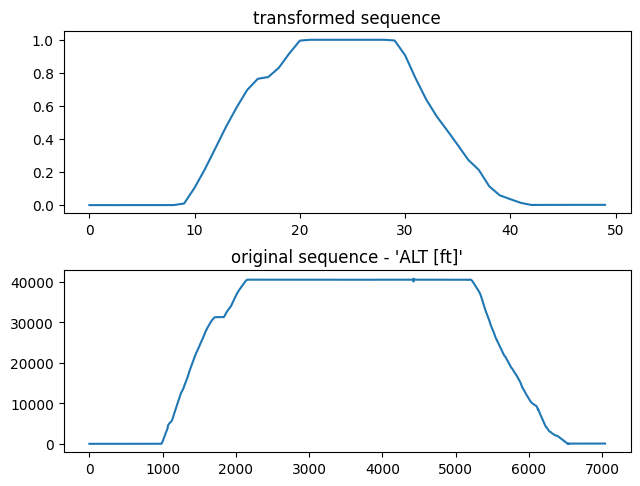

In [11]:
flight_vector, _, _, _ = flight_to_vector(df, "ALT [ft]", samples_per_phase)

fig, ax = plt.subplots(2, 1)
fig.tight_layout(h_pad=2)

ax[0].plot(flight_vector)
ax[0].set_title("transformed sequence")

ax[1].plot(df["ALT [ft]"])

ax[1].set_title("original sequence - 'ALT [ft]'")

plt.show()

Define a function to generate the output table:

In [12]:
def create_flight_table(store):
    to_remove = []

    flight_table = []
    flight_names = []
    flight_metadata = []

    for df in store:
        try:
            output = flight_to_vector(df, "ALT [ft]", samples_per_phase)
            
            flight_table.append(output[0])
            flight_names.append(df.index.name)
            flight_metadata.append(output[1:])
            
        except:
            to_remove.append(df.index.name)
    
    # mount table
    flight_index = pd.Index(flight_names)
    flight_table = pd.DataFrame(flight_table, index=flight_index)

    return flight_table, flight_metadata, to_remove

In [13]:
flight_table, flight_metadata, to_remove = create_flight_table(cleanstore)

print("Total convered:", flight_table.shape[0])
print("Could not convert the folowing record:", to_remove)

Total convered: 995
Could not convert the folowing record: ['record_438']


The resulting table:

In [14]:
flight_table.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
record_00,0.000206,0.000243,0.000123,0.000033,0.000074,0.000132,0.000293,0.000308,0.000000,0.010674,...,0.032345,0.005694,0.004567,0.004203,0.004322,0.004558,0.004729,0.004880,0.004890,0.004896
record_01,0.005669,0.005698,0.005731,0.005689,0.005718,0.005700,0.005675,0.005630,0.005816,0.019500,...,0.028731,0.002086,0.000338,0.000237,0.000000,0.000227,0.000261,0.000259,0.000189,0.000254
record_02,0.000000,0.000050,0.000043,0.000043,0.000289,0.000249,0.000304,0.000273,0.000305,0.009607,...,0.035907,0.013534,0.001042,0.001288,0.001451,0.001508,0.001571,0.001599,0.001599,0.001599
record_03,0.000926,0.000946,0.000857,0.000859,0.000875,0.000964,0.000672,0.000196,0.000069,0.013497,...,0.031581,0.005812,0.000342,0.000114,0.000138,0.000246,0.000261,0.000035,0.000000,0.000040
record_04,0.000605,0.000463,0.000404,0.000487,0.000492,0.000567,0.000889,0.000875,0.000748,0.008076,...,0.030996,0.004319,0.000491,0.000016,0.000280,0.000000,0.000311,0.000473,0.000637,0.000563


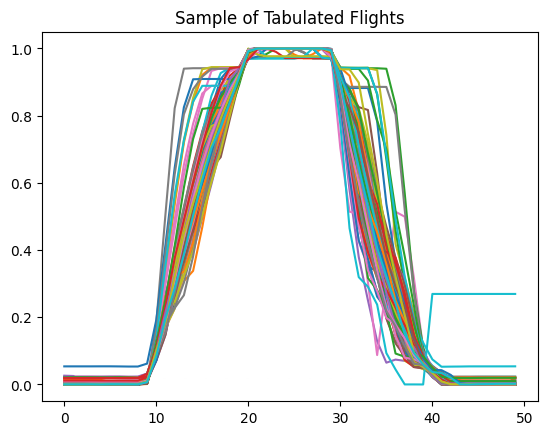

In [15]:
plt.plot(flight_table.head(200).T)
plt.title("Sample of Tabulated Flights")
plt.show()

Write resulting table to a file:

In [16]:
flight_table.to_csv(tablepath, index=True)
pkl.dump(flight_metadata, open(metadatapath, "wb"))

### Reconstruction:

In order to recover (approximate) the complete data $(m^{v, p}_i)_{i=0}^{k}$ from the vectorial representation, we just expand back each average into an interval by repeating the average values, that is, just take $\hat{m}^{v, p}_i = u_j$ if $t_{j-1} < i < t_{j}$. We also need to denormalize, that is, expand the vector to the original extension by translating and scalling, thus the informations necessaire to reconstruct the curve are: original lenght, scaling factors and phase transitions.

In [17]:
def vector_to_flight_phase(vector, K):
    L = len(vector)

    # defines intervals
    inds = np.interp(range(L+1), [0, L], [0, K]).astype(int)
    
    # mount sequence
    sequence = np.empty(K)
    for i in range(1,len(inds)):
        sequence[inds[i-1]:inds[i]] = vector[i-1]
    
    return sequence

def vector_to_flight(vector, vec_min, vec_var, phase_indexes):
    L = int(len(vector)/5)
    
    # denormalize
    vector = vector*vec_var+vec_min
    
    # intervals
    sequences = []
    for i in range(5):
        phase = vector[i*L:(i+1)*L]
        K = phase_indexes[i+1] - phase_indexes[i]
        sequence_phase = vector_to_flight_phase(phase, K)
        sequences.append(sequence_phase)

    # concatenate
    sequence = np.concat(sequences)

    return sequence

In [18]:
# transform in vector
transformed = flight_to_vector(df, "ALT [ft]", samples_per_phase)

# transforms back
sequence = vector_to_flight(*transformed)

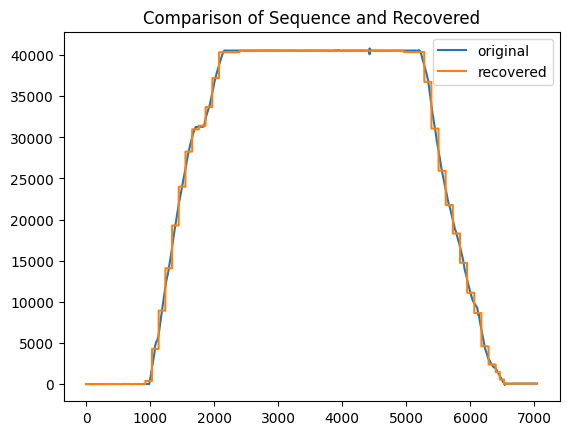

In [19]:
plt.plot(df["ALT [ft]"], label="original")
plt.plot(sequence, label="recovered")

plt.title("Comparison of Sequence and Recovered")
plt.legend()
plt.show()

### Quality Metrics

We define the codes responsible for computing the required quality metrics: compression ratio; reconstruction error; and Synchronization.

In [20]:
def compute_compression_ratio(store, flight_table):
    # compute initial size
    size_original = 0
    for df in store:
        if df.index.name in flight_table.index:
            size_original += df.index.shape[0]
    
    # cmpute compressed size
    size_compressed = flight_table.shape[0]*flight_table.shape[1]

    return size_compressed/size_original

In [21]:
def compute_reconstruction_error(store, column, flight_table, flight_metadata, fun):
    i = 0
    errors = []
    for df in store:
        index = df.index.name
        if index in flight_table.index:
            # access and reconstruct
            vector = flight_table.loc[index].array
            meta = flight_metadata[i]
            sequence = fun(vector, *meta)
            
            # normalize vertically
            max_ref = max(sequence.max(), df[column].array.max())
            min_ref = min(sequence.min(), df[column].array.min())

            # compute error
            sequence_reco = (sequence-min_ref)/(max_ref-min_ref)
            sequence_orig = (df[column].array-min_ref)/(max_ref-min_ref)
            err = np.linalg.norm(sequence_reco, sequence_orig)
            errors.append(err)

            i += 1

    return np.mean(errors)

In [22]:
def compute_global_syncronization(flight_table):
    upper_bound = flight_table.max(axis=0)
    lower_bound = flight_table.min(axis=0)
    
    return np.sum(upper_bound-lower_bound)

def compute_local_syncronization(flight_table):
    vector = flight_table.median(axis=0)

    errors = []
    for index in flight_table.index:
        # access curve
        vector = flight_table.loc[index].array

        # compute error
        err = np.linalg.norm(vector, vector)**2
        errors.append(err)
    
    return np.mean(errors)

Then we compute the metrics as follows:

In [23]:
compression_ration = compute_compression_ratio(cleanstore, flight_table)
reconstruction_error = compute_reconstruction_error(store, 'ALT [ft]',
                                                    flight_table,
                                                    flight_metadata,
                                                    vector_to_flight)
global_syncronization = compute_global_syncronization(flight_table)
local_syncronization = compute_local_syncronization(flight_table)

print("Compression Ration:", compression_ration)
print("Reconstruction Error:", reconstruction_error)
print("Global Syncronization:", global_syncronization)
print("Local Syncronization:", local_syncronization)

Compression Ration: 0.0065857892039124484
Reconstruction Error: 61.8677818172415
Global Syncronization: 16.39309983693545
Local Syncronization: 16.314577977369453


## Benchmark

For this example, we use a simple uniform grid from which samples are taken:

In [24]:
def simple_flight_to_vector(df, column, L):
    sequence = df[column].array

    K = len(sequence)
    # defines intervals
    inds = np.linspace(0, K-1, L).astype(int)

    # mount vector
    vector = np.empty(L)
    for i, ind in enumerate(inds):
        vector[i] = sequence[ind]

    # normalize
    vec_min = vector.min()
    vec_var = vector.max() - vector.min()
    vector = (vector-vec_min)/vec_var

    return vector, vec_min, vec_var, df.shape[0]

In [25]:
def create_simple_table(store, column, L):
    flight_table = []
    flight_names = []
    flight_metadata = []

    for df in store:
        output = simple_flight_to_vector(df, column, L)
            
        flight_table.append(output[0])
        flight_names.append(df.index.name)
        flight_metadata.append(output[1:])
    
    # mount table
    flight_index = pd.Index(flight_names)
    flight_table = pd.DataFrame(flight_table, index=flight_index)

    return flight_table, flight_metadata

# create simple table
simple_table, simple_metadata = create_simple_table(cleanstore, "ALT [ft]", 5*samples_per_phase)

Show the resulting simple table:

In [26]:
simple_table.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
record_00,0.000235,0.000235,0.000000,0.000118,0.000353,0.000118,0.064550,0.212228,0.410817,0.603645,...,0.347208,0.203527,0.127219,0.052910,0.003410,0.004115,0.004468,0.004703,0.004938,0.004938
record_01,0.005875,0.005992,0.005992,0.005992,0.005992,0.096581,0.237575,0.434144,0.589825,0.735636,...,0.306897,0.215956,0.125485,0.059570,0.021032,0.000470,0.000000,0.000470,0.000352,0.000470
record_02,0.000000,0.000114,0.000000,0.000342,0.000228,0.000000,0.000342,0.020205,0.171461,0.350228,...,0.475000,0.366324,0.251142,0.157534,0.062671,0.022489,0.001484,0.001598,0.001598,0.001598
record_03,0.000999,0.000888,0.000888,0.001110,0.000000,0.013435,0.128137,0.313014,0.482012,0.627693,...,0.180768,0.097268,0.055963,0.055185,0.006773,0.000000,0.000000,0.000333,0.000222,0.000111
record_04,0.000551,0.000413,0.000275,0.000413,0.000413,0.000826,0.000964,0.000826,0.094753,0.246523,...,0.070376,0.070101,0.044897,0.004545,0.000551,0.000138,0.000000,0.000413,0.000413,0.000413


Visualization of a sample of the compressed data:

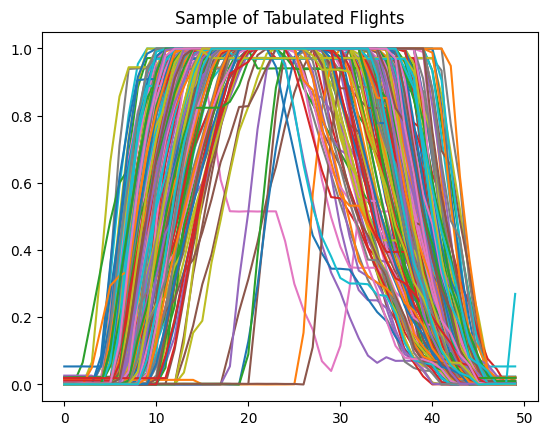

In [27]:
plt.plot(simple_table.head(200).T)
plt.title("Sample of Tabulated Flights")
plt.show()

And the recostruction:

In [28]:
def simple_vector_to_flight(vector, vec_min, vec_var, lenght_flight):
    L = len(vector)
    K = lenght_flight

    # denormalize
    vector = vector*vec_var+vec_min

    # defines intervals
    inds = np.linspace(0, K-1, L).astype(int)
    
    # mount sequence
    sequence = np.empty(K)
    for i in range(1,len(inds)):
        interp = np.linspace(vector[i-1], vector[i], inds[i]-inds[i-1])
        sequence[inds[i-1]:inds[i]] = interp
    
    return sequence

In [29]:
# transform in vector
transformed = simple_flight_to_vector(df, "ALT [ft]", samples_per_phase)

# transforms back
sequence = simple_vector_to_flight(*transformed)

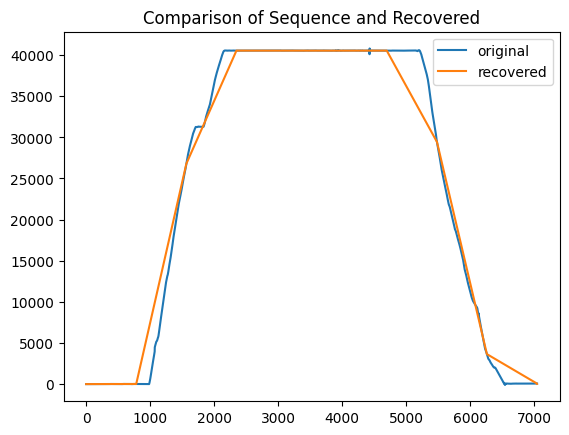

In [30]:
plt.plot(df["ALT [ft]"], label="original")
plt.plot(sequence, label="recovered")

plt.title("Comparison of Sequence and Recovered")
plt.legend()
plt.show()

Finally, we compute the metrics:

In [31]:
simple_compression_ration = compute_compression_ratio(cleanstore, simple_table)
simple_reconstruction_error = compute_reconstruction_error(cleanstore, 'ALT [ft]',
                                                           simple_table,
                                                           simple_metadata,
                                                           simple_vector_to_flight)
simple_global_syncronization = compute_global_syncronization(simple_table)
simple_local_syncronization = compute_local_syncronization(simple_table)

print("Compression Ration:", simple_compression_ration)
print("Reconstruction Error:", simple_reconstruction_error)
print("Global Syncronization:", simple_global_syncronization)
print("Local Syncronization:", simple_local_syncronization)

Compression Ration: 0.006589349864045041
Reconstruction Error: nan
Global Syncronization: 45.991124562441115
Local Syncronization: 25.050545669089406


## Anomally Detection

A simple initial approach for anomaly detection is PCA. We propose the use of PCA, we can observe a 2d representation of the 50d tables. We do that as follows:

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
flight_table_pca = pca.fit_transform(flight_table)

In [33]:
print("Ratio of variance explained:", pca.explained_variance_ratio_.sum())

Ratio of variance explained: 0.7844592907815195


We see that the 2d representation is enough to capture almost 80% of the variance in the data. Now, we are able to plot and visualize:

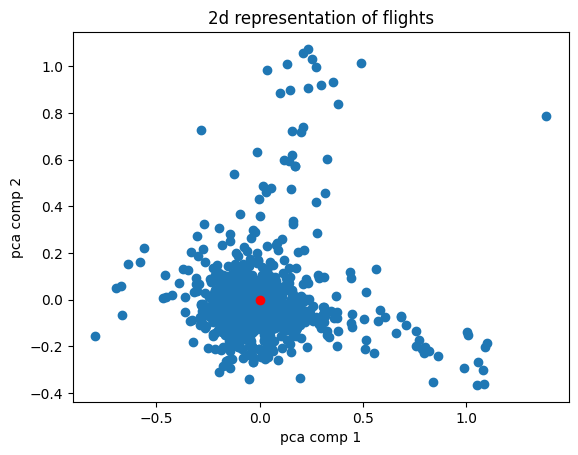

In [34]:
baricenter = flight_table_pca.mean(axis=0)

plt.scatter(flight_table_pca[:,0], flight_table_pca[:,1])
plt.scatter(baricenter[0], baricenter[1], c="r")

plt.title("2d representation of flights")
plt.xlabel("pca comp 1")
plt.ylabel("pca comp 2")
plt.show()

Observe that there's a region where the points are concentrated, and points far from that. We suspect that such points far from the center represent outliers. We compute the distance of each point to the baricenter:

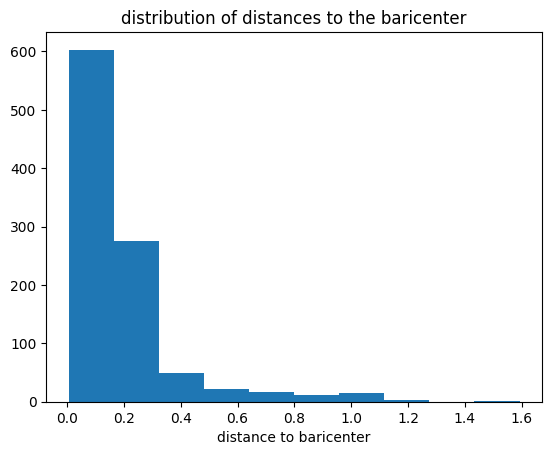

In [35]:
distances = np.linalg.norm(flight_table_pca - baricenter, axis=1)

plt.hist(distances)
plt.title("distribution of distances to the baricenter")
plt.xlabel("distance to baricenter")
plt.show()

Finally, we inspect the most distance points from the baricenter:

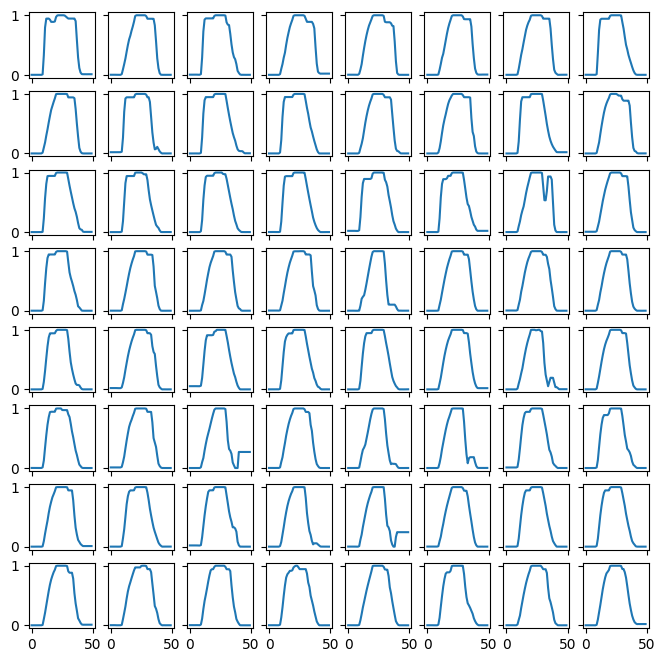

In [36]:
ordered_indices = np.flip(np.argsort(distances))

n_cols = 8
n_rows = 8
fig, ax = plt.subplots(n_rows, n_cols, sharex=True,
                       sharey=True, figsize=(n_rows, n_cols))

c = 0
for i in range(n_rows):
    for j in range(n_cols):
        ax[i][j].plot(flight_table.iloc[ordered_indices[c]])
        c += 1

Not all flights observed flights appear to appear to be abnormal, this is in part due to the process of defining flight stages by a simple rule. On the other side, some uncommon behaviors are still observed, such as abrupt altitude drop during cruise, and incomplete landing attempts.